In [1]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.applications import ResNet152V2 , MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir,label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                new_img = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(new_img,(img_size,img_size))
                data.append([resized_img,class_num])
            except:
                continue
    return np.array(data)      
    

In [3]:
train = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/train')
test = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/test')
val = get_data('E:/Chest X-Ray Images/chest_xray/chest_xray/val')

C:\Users\Home\anaconda3\lib\site-packages\ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [4]:
X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for img,label in train:
    X_train.append(img)
    y_train.append(label)

for img,label in test:
    X_test.append(img)
    y_test.append(label)

for img,label in val:
    X_val.append(img)
    y_val.append(label)


In [5]:
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_val = np.array(X_val)/255

X_train = X_train.reshape(-1,img_size,img_size,1)
X_test = X_test.reshape(-1,img_size,img_size,1)
X_val = X_val.reshape(-1,img_size,img_size,1)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)


In [6]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [7]:
#CNN Model with BatchNormalization and Dropout

model2 = Sequential([
    Conv2D(filters = 64,kernel_size = (3,3), strides = 1, padding='same', input_shape = (img_size,img_size,1), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),strides=2,padding='same'),
    Dropout(0.2),
    
    Conv2D(filters = 64,kernel_size = (3,3), strides = 1, padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),strides=2,padding='same'),
    Dropout(0.2),
    
    Conv2D(filters = 128,kernel_size = (3,3), strides = 1, padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),strides=2,padding='same'),
    Dropout(0.2),
    
    Conv2D(filters = 256,kernel_size = (3,3), strides = 1, padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2),strides=2,padding='same'),
    Dropout(0.2),
    
    Flatten(),
    Dense(units=256,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(units=128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(units=1,activation='sigmoid')   
])

model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [9]:
history2 = model2.fit(datagen.flow(X_train,y_train,batch_size=32),epochs=10,validation_data=datagen.flow(X_test,y_test),callbacks=[reduce_lr])

Epoch 1/10
163/163 [==============================] - 1096s 7s/step - loss: 0.6496 - accuracy: 0.7166 - val_loss: 1.2482 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 1041s 6s/step - loss: 0.3256 - accuracy: 0.8736 - val_loss: 2.2905 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 1036s 6s/step - loss: 0.2428 - accuracy: 0.9050 - val_loss: 2.2534 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 934s 6s/step - loss: 0.2230 - accuracy: 0.9159 - val_loss: 0.6621 - val_accuracy: 0.7548
Epoch 5/10
163/163 [==============================] - 849s 5s/step - loss: 0.1883 - accuracy: 0.9244 - val_loss: 3.1410 - val_accuracy: 0.6250
Epoch 6/10
163/163 [==============================] - 856s 5s/step - loss: 0.1875 - accuracy: 0.9250 - val_loss: 3.0017 - val_accuracy: 0.4343
Epoch 7/10
163/163 [==============================] - 851s 5s/step - loss: 0.1970 - accuracy: 0.9276 - val_loss: 2.4812 - val_accuracy: 0.6

In [10]:
model2.evaluate(X_test,y_test)

20/20 [==============================] - 19s 759ms/step - loss: 0.4684 - accuracy: 0.7965


[0.468422532081604, 0.7964743375778198]

In [11]:
model2.evaluate(X_val,y_val)

1/1 [==============================] - 0s 442ms/step - loss: 0.8982 - accuracy: 0.6250


[0.8981797695159912, 0.625]

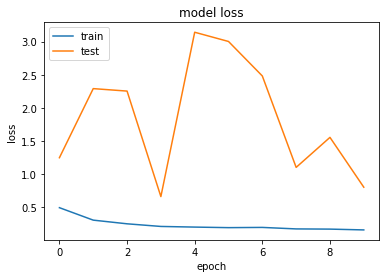

In [12]:
# plotting training set and validation test 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()